In [1]:
import numpy as np 
import pandas as pd

In [2]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [3]:
import time
import pandas_datareader as pdr

import keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('yahoo_stock.csv')
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [6]:
df["Date"] = pd.to_datetime(df["Date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1825 non-null   datetime64[ns]
 1   High       1825 non-null   float64       
 2   Low        1825 non-null   float64       
 3   Open       1825 non-null   float64       
 4   Close      1825 non-null   float64       
 5   Volume     1825 non-null   float64       
 6   Adj Close  1825 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 99.9 KB


In [8]:
df["Date"].min(), df["Date"].max()

(Timestamp('2015-11-23 00:00:00'), Timestamp('2020-11-20 00:00:00'))

In [9]:
df.set_index("Date",inplace=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


Text(0.5, 1.0, 'Plotting Price against the Entire Timeframe For all the columns')

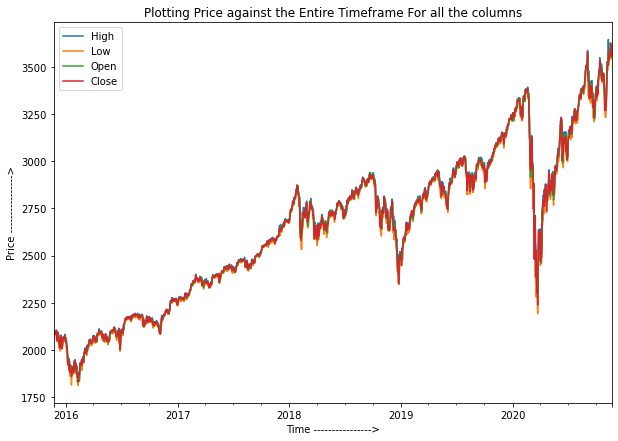

In [10]:
df[["High", "Low", "Open", "Close"]].plot(figsize=(10,7))
plt.legend(loc="best")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Price against the Entire Timeframe For all the columns")

Text(0.5, 1.0, 'Plotting Price against the Entire Timeframe For HIGH column')

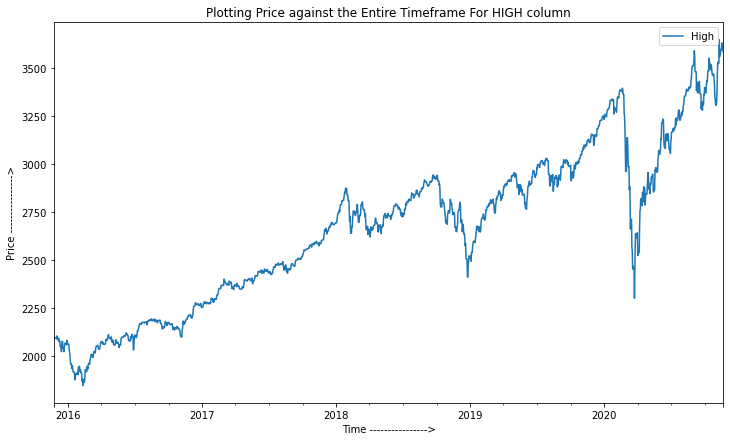

In [11]:
plt.figure(figsize=(12,7))
df["High"].plot()
plt.legend(loc="best")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Plotting Price against the Entire Timeframe For HIGH column")

All 4 plots follow the same pattern, so we can choose any.

In [12]:
new_df = pd.DataFrame(df["High"].copy(), columns=["High"])
new_df.head()

,High
Date,
2015-11-23,2095.610107
2015-11-24,2094.120117
2015-11-25,2093.000000
2015-11-26,2093.000000
2015-11-27,2093.290039


In [13]:
train_size = int(len(new_df)*0.8)

train = new_df.iloc[0:train_size]
test = new_df.iloc[train_size:len(new_df)]

In [14]:
len(train), len(test)

(1460, 365)

In [15]:
def create_dataset(X, y, lag=1):
    xs,ys = [], []
    
    for i in range(len(X) - lag):
        tmp = X.iloc[i: i+lag].values
        xs.append(tmp)
        ys.append(y.iloc[i+lag])
    
    return np.array(xs), np.array(ys)

In [16]:
xtrain, ytrain = create_dataset(train, train["High"],10)
xtest, ytest = create_dataset(test, test["High"],10)

In [17]:
xtrain[0]

array([[2095.61010742],
       [2094.12011719],
       [2093.        ],
       [2093.        ],
       [2093.29003906],
       [2093.29003906],
       [2093.29003906],
       [2093.81005859],
       [2103.37011719],
       [2104.27001953]])

In [18]:
ytrain[0]

2085.0

In [19]:
xtrain.shape

(1450, 10, 1)

# LSTM Model

In [20]:
model = Sequential()
model.add(LSTM(50,activation='relu', input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

2023-01-16 22:12:15.204241: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
model.fit(xtrain, ytrain,
         epochs=10,
         batch_size=10,
         verbose=1,
         shuffle=False
         )

Epoch 1/10
145/145 [==============================] - 2s 5ms/step - loss: 97161.4766
Epoch 2/10
145/145 [==============================] - 1s 5ms/step - loss: 2001.1865
Epoch 3/10
145/145 [==============================] - 1s 5ms/step - loss: 2197.9810
Epoch 4/10
145/145 [==============================] - 1s 5ms/step - loss: 2294.0002
Epoch 5/10
145/145 [==============================] - 1s 4ms/step - loss: 2321.1289
Epoch 6/10
145/145 [==============================] - 1s 4ms/step - loss: 2367.8301
Epoch 7/10
145/145 [==============================] - 1s 4ms/step - loss: 2149.5664
Epoch 8/10
145/145 [==============================] - 1s 4ms/step - loss: 1843.4703
Epoch 9/10
145/145 [==============================] - 1s 4ms/step - loss: 1828.1471
Epoch 10/10
145/145 [==============================] - 1s 4ms/step - loss: 1860.0674


In [22]:
ypred = model.predict(xtest)

Text(0.5, 1.0, 'Predicted And Actual Values Together against the Entire Timeframe')

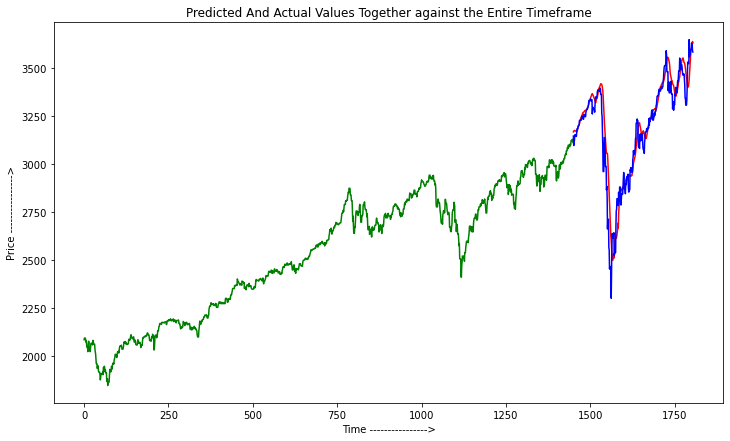

In [23]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="history")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="Predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Predicted And Actual Values Together against the Entire Timeframe")

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred,squared=False)

92.43786343040806

Text(0.5, 1.0, 'Predicted And Actual Values Together against the Testing Timeframe')

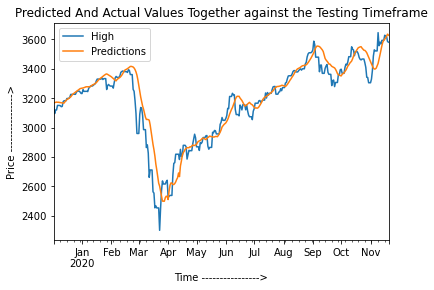

In [25]:
test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Predicted And Actual Values Together against the Testing Timeframe")

# LSTM Model with Two Layers

In [29]:
from keras.layers import SimpleRNN

In [31]:
model = Sequential()
model.add(SimpleRNN(100, activation='relu',
           input_shape=(10,1), 
           return_sequences=True))
model.add(Dropout(0.2))

# hidden layer 2
model.add(LSTM(100,activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

In [32]:
#callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            patience=2,
#                                            verbose=0)]
model.fit(xtrain, ytrain, 
               epochs=20, batch_size=16,
               verbose=1
               #validation_split=0.05,
               )

Epoch 1/20
91/91 [==============================] - 3s 14ms/step - loss: 2018129.0000
Epoch 2/20
91/91 [==============================] - 1s 14ms/step - loss: 399061.3125
Epoch 3/20
91/91 [==============================] - 1s 10ms/step - loss: 307367.2500
Epoch 4/20
91/91 [==============================] - 1s 12ms/step - loss: 221077.2500
Epoch 5/20
91/91 [==============================] - 1s 11ms/step - loss: 224255.1406
Epoch 6/20
91/91 [==============================] - 1s 9ms/step - loss: 203571.6250
Epoch 7/20
91/91 [==============================] - 1s 12ms/step - loss: 264881.4375
Epoch 8/20
91/91 [==============================] - 1s 10ms/step - loss: 197175.1875
Epoch 9/20
91/91 [==============================] - 1s 13ms/step - loss: 168329.6250
Epoch 10/20
91/91 [==============================] - 1s 11ms/step - loss: 191876.6562
Epoch 11/20
91/91 [==============================] - 1s 11ms/step - loss: 171544.3281
Epoch 12/20
91/91 [==============================] - 1s 12ms/st

In [33]:
ypred = model.predict(xtest)

Text(0.5, 1.0, 'Predicted And Actual Values Together')

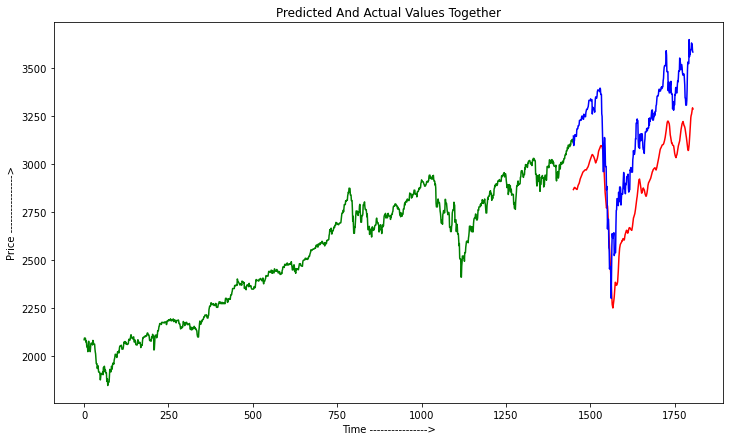

In [35]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(0, len(xtrain)), ytrain, 'g', label="history")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ypred, 'r', label="predictions")
plt.plot(np.arange(len(xtrain), len(xtrain) + len(xtest)), ytest, 'b', label="Actual")
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Predicted And Actual Values Together")

In [36]:
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest, ypred,squared=False)

294.02772278708625

Text(0.5, 1.0, 'Predicted And Actual Values Together against the Testing Timeframe')

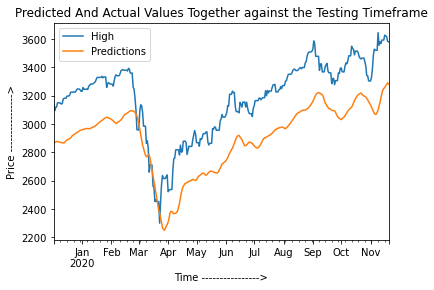

In [37]:
test = new_df.iloc[train_size+10:].copy()

test["Predictions"] = ypred
test[["High", "Predictions"]].plot()
plt.xlabel("Time ---------------->")
plt.ylabel("Price ---------------->")
plt.title("Predicted And Actual Values Together against the Testing Timeframe")